## Same intial loading and cleaning steps ##

In [41]:
# Image Preparation Imports
import cv2
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
from glob import glob
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

file_name = '../data/wiki.mat'

def matlab_datenum_to_date(matlab_dn):
    return datetime.date.fromordinal(int(matlab_dn) - 366)

def compute_wiki_age(photo_year, birth_datenum):
    photo_date = datetime.date(photo_year, 7, 1)
    birth_date = matlab_datenum_to_date(birth_datenum)
    delta = photo_date - birth_date
    return delta.days / 365.2425


def process_matfile(file_name):
    # Load the data
    data = loadmat(file_name)['wiki'][0, 0]
    data_dict = {key: data[key] for key in data.dtype.names}

    # Convert data into filename-based dictionary
    filename_dict = {}

    for i in range(len(data_dict['full_path'][0])):
        # Remove invalid faces
        if np.isinf(data_dict['face_score'][0][i]) or not np.isnan(data_dict['second_face_score'][0][i]):
            continue

        filename = data_dict['full_path'][0][i][0]
        filename_dict[filename] = compute_wiki_age(data_dict['photo_taken'][0][i], data_dict['dob'][0][i])

    return filename_dict

# Load filenames anda ssociated data
data = process_matfile(file_name)

In [42]:
#some data cleaning to get rid of excessively large or negative values in the predicted age category
print(len(data))
mean_val = sum(data.values()) / len(data)
print(mean_val)
for key in list(data.keys()):
    if data[key] > 100 or data[key] < 1:
        del data[key]
print(len(data))
print(min(data.values()), max(data.values()))

40216
38.60996556567274
40147
1.3525260614523227 99.87337180092678


In [43]:
# Load in images
images = []
for i in data.keys():  
    img = cv2.imread('../data/wiki_crop/'+i)
    images.append(img)

print(f"Number of images loaded: {len(images)}")

Number of images loaded: 40147


In [44]:
#resize all images (can change width and height to what we find to be best)
new_images = []
width = 128
height = 128
for image in images:
    new_im = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
    new_im = cv2.cvtColor((cv2.resize(image, (width,height), interpolation=cv2.INTER_LINEAR)), cv2.COLOR_BGR2RGB)
    new_images.append(new_im)

## new way to classify ages into bins of 5 ##

In [45]:
# edges = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
# labels = ['0-5 years', '5-10 years', '10-15 years', '15-20 years',
#               '20-25 years', '25-30 years', '30-35 years', '35-40 years',
#              '40-45 years', '45-50 years', '50-55 years', '55-60 years',
#               '60-65 years', '65-70 years', '70-75 years', '75-80 years', 
#              '80-85 years', '85-90 years', '90-95 years', '95-100 years']

# def classify_age(age, edges, labels):
#     for i in range(len(edges) - 1):
#         if edges[i] <= age < edges[i + 1]:
#             return labels[i]
#     return None  

# classification = [classify_age(data[key], edges, labels) for key in data.keys()]

classification = [data[key] for key in data.keys()]

In [46]:
# split in to train and test sets
x_train, x_test, y_train, y_test = train_test_split(new_images, classification, test_size = 0.2, random_state = 42)

In [50]:
# int_labels = sorted(set(y_train))
# label_to_int_mapping = {label: idx for idx, label in enumerate(int_labels)}

# def label_to_int(label):
#     return label_to_int_mapping[label]

# # Convert datasets
# X_train = np.array(x_train, dtype='float32')
# X_test = np.array(x_test, dtype='float32')

# # Map labels to integers
# y_train_int = np.array([label_to_int(lbl) for lbl in y_train], dtype='int32')
# y_test_int = np.array([label_to_int(lbl) for lbl in y_test], dtype='int32')

# y_train_int = np.array([label_to_int(lbl) for lbl in y_train], dtype='int32')
# y_test_int = np.array([label_to_int(lbl) for lbl in y_test], dtype='int32')

# Normalize pixel values to range [0, 1]
X_train = np.array(x_train, dtype='float32') / 255.0
X_test = np.array(x_test, dtype='float32') / 255.0

y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32117, 128, 128, 3)
y_train shape: (32117,)


In [62]:
model = Sequential([
    # Conv2D(32, (3,3), activation='relu', input_shape=(height, width, 3)),
    # MaxPooling2D((2,2)),

    # Conv2D(64, (3,3), activation='relu'),
    # MaxPooling2D((2,2)),

    # Flatten(),
    # Dense(128, activation='relu'),
    # Dense(20, activation='softmax')  #the 20 different categories for age

    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),   

    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),   

    Flatten(),

    Dense(256, activation='relu'),

    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error', 
    metrics=['mae']  
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  # 10% of training as validation
    epochs=10,
    batch_size=32,
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_acc:.4f}")

predictions = model.predict(X_test[:5])
pred_classes = np.argmax(predictions, axis=1)

Epoch 1/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 63s 68ms/step - loss: 360.3050 - mae: 14.5979 - val_loss: 208.5630 - val_mae: 11.6807
Epoch 2/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 59s 65ms/step - loss: 194.2335 - mae: 10.8871 - val_loss: 168.5152 - val_mae: 10.2429
Epoch 3/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - loss: 166.2236 - mae: 9.9276 - val_loss: 217.1691 - val_mae: 12.0398
Epoch 4/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - loss: 146.0934 - mae: 9.2785 - val_loss: 184.8010 - val_mae: 10.0816
Epoch 5/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - loss: 132.2029 - mae: 8.7543 - val_loss: 132.2354 - val_mae: 8.7568
Epoch 6/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - loss: 116.3978 - mae: 8.2077 - val_loss: 126.3211 - val_mae: 8.7633
Epoch 7/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - loss: 106.9315 - mae: 7.8515 - val_loss: 124.4782 - val_mae: 8.8123
Epoch 8/10
904/904 ━━━━━━━━━━━━━━━━━━━━ 57s 63ms/step - loss: 96.0849 - mae: 7.4506 - val_loss: 121.1767 - val_mae: 8.2663
Epo

In [ ]:
print("\nSample Predictions:")
for i in range(5):
    predicted_label = pred_classes[i]
    actual_label = y_test[i]
    print(f"Predicted: {predicted_label}, Actual: {actual_label}")


Sample Predictions:
Predicted: 0, Actual: 37.76121520996094
Predicted: 0, Actual: 57.049766540527344
Predicted: 0, Actual: 17.826513290405273
Predicted: 0, Actual: 20.77250099182129
Predicted: 0, Actual: 43.007041931152344


KeyError: 'val_accuracy'

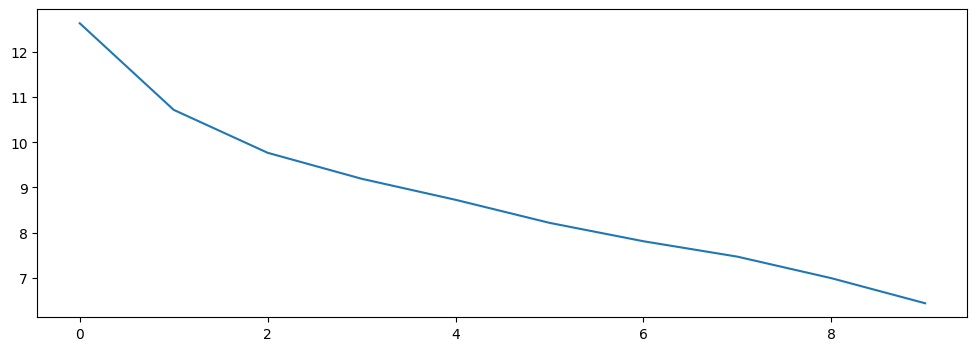

In [68]:
# Plotting results
plt.figure(figsize=(12, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
